In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pyapep.isofit as isof
import pyapep.simide as simi

import matplotlib.pyplot as plt
import numpy as np

parameters = {'axes.labelsize': 17,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams['font.family'] = 'arial'

from sklearn.metrics import r2_score
from scipy.optimize import minimize

from utils import *

In [2]:
core_mof = pd.read_csv('RawData/0.2019-07-01-ASR-public_12020.csv', index_col=0)

rm_diso = core_mof[core_mof['DISORDER'] != 'DISORDER']
rm_charged = rm_diso[rm_diso['Extension'] != 'charged']

In [3]:
pre_metal = ['Au', 'Ag', 'Pt', 'Pd', 'Ru', 'Rh', 'Y', 'In', 
             'Hf', 'Ga', 'Dy', 'Pr', 'Te', 'U', 'Se', 'Mo',
             'Sm', 'Nd', 'Pr', 'Gd', 'Ir', 'Eu', 'La', 'Tb',
             'Tm']

metal_cond_list = []
for ii in range(len(rm_charged)):
    metals = rm_charged.iloc[ii,:]['All_Metals']
    metal_list = metals.split(',')
    metal_cond = [True if _metal in pre_metal else False for _metal in  metal_list]
    
    rm_cond = bool(np.sum(metal_cond))
    metal_cond_list.append(rm_cond)

In [4]:
rm_charged['Metal_cond'] = metal_cond_list

rm_metal = rm_charged[rm_charged['Metal_cond'] != True]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_344708\1431823713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rm_charged['Metal_cond'] = metal_cond_list


# PLD screening

In [5]:
rm_pld = rm_metal[rm_metal['PLD'] > 3.8]
len(rm_pld)

4925

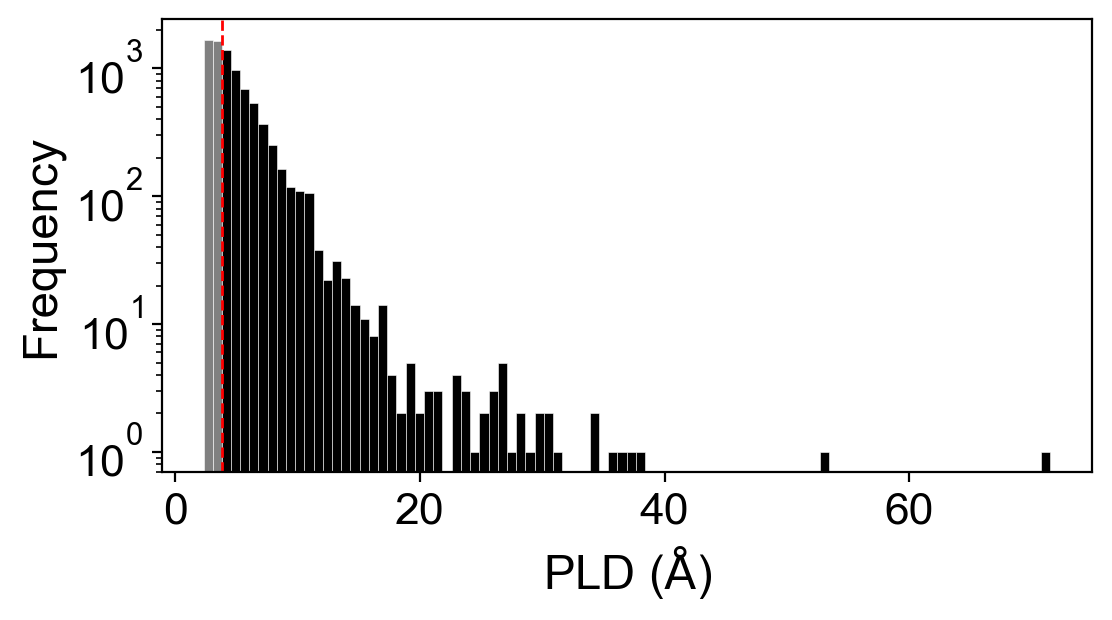

In [6]:
plt.figure(dpi=200, figsize = (6,3))
plt.hist(rm_metal[rm_metal['PLD']<=3.8]['PLD'], bins=2, color='grey', edgecolor='white', linewidth = 0.2)
plt.hist(rm_metal[rm_metal['PLD']>3.8]['PLD'], bins=90, color='k', edgecolor='white', linewidth = 0.2)
plt.axvline(3.8, c='r', linestyle = '--', linewidth=1)
plt.yscale('log')
plt.xlabel('PLD ($\mathrm{\AA}$)')
plt.ylabel('Frequency')
plt.show()

# working capacity & selectivity

In [7]:
data = pd.read_csv('RawData/1.2point_GCMC.csv', index_col=0)
data.columns

Index(['Adsorbent', 'Directory', 'co2_0.1bar', 'co2_2.67bar', 'CH4_0.2bar',
       'CH4_5.33bar', 'CO2_wc', 'CH4_wc', 'CO2_sc'],
      dtype='object')

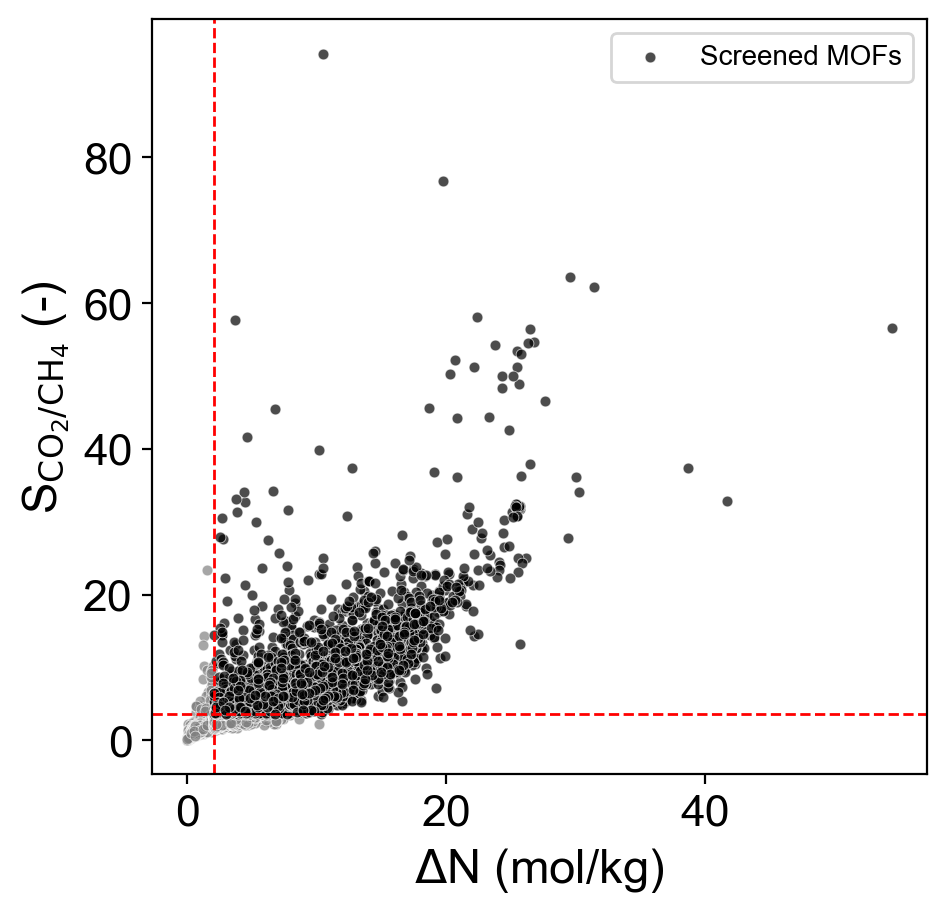

In [8]:
N_threshold = data['CO2_wc'].quantile(0.2)
N_low = data[(data['CO2_wc']<N_threshold)]
N_high = data[(data['CO2_wc']>N_threshold)]

S_threshold = N_high['CO2_sc'].quantile(0.2)
S_low = N_high[(N_high['CO2_sc']<S_threshold)]
S_high = N_high[(N_high['CO2_sc']>S_threshold)]

mof_ex = pd.concat([N_low, S_low])
mof_in = S_high.copy()

plt.figure(dpi=200, figsize=(5,5))
plt.scatter(mof_ex['CO2_wc'], mof_ex['CO2_sc'], s=15, alpha=0.7, edgecolors='white', linewidths=0.3, c='grey')
plt.scatter(mof_in['CO2_wc'], mof_in['CO2_sc'], s=15, alpha=0.7, edgecolors='white', linewidths=0.3, c='k', label='Screened MOFs')
plt.axhline(S_threshold, c='r', linestyle = '--', linewidth=1)
plt.axvline(N_threshold, c='r', linestyle = '--', linewidth=1)
plt.legend(loc='best')
plt.ylabel('S$\mathrm{_{CO_2/CH_4}}$ (-)')
plt.xlabel('$\Delta$N (mol/kg)')
plt.show()

# Pure isotherm fitting results

In [9]:
data = pd.read_csv('RawData/2.StepwiseIsoFit.csv')
data.fillna('NaN', inplace=True)
data.columns

Index(['Adsorbent', 'CO2_0.1bar', 'CO2_2.67bar', 'CH4_0.2bar', 'CH4_5.33bar',
       'CO2_wc', 'CH4_wc', 'CO2_sc', 'CO2_3p', 'CH4_3p', 'CO2_3p_sim',
       'CH4_3p_sim', 'CH4_Isotherm_1', 'par_1_CH4', 'par_2_CH4',
       'Acc_CH4(-R2)', 'CO2_Isotherm_1', 'par_1_CO2', 'par_2_CO2',
       'Acc_CO2(-R2)', 'CO2_4p', 'CH4_4p', 'CO2_4p_sim', 'CH4_4p_sim',
       'CH4_Isotherm_2', 'par_CH4_2', 'Acc_CH4(-R2)_2', 'CO2_Isotherm_2',
       'par_CO2_2', 'Acc_CO2(-R2)_2', 'CO2_5p', 'CO2_5p_sim', 'CO2_Isotherm_3',
       'par_CO2_3', 'Acc_CO2(-R2)_3', 'CH4_Isotherm_3'],
      dtype='object')

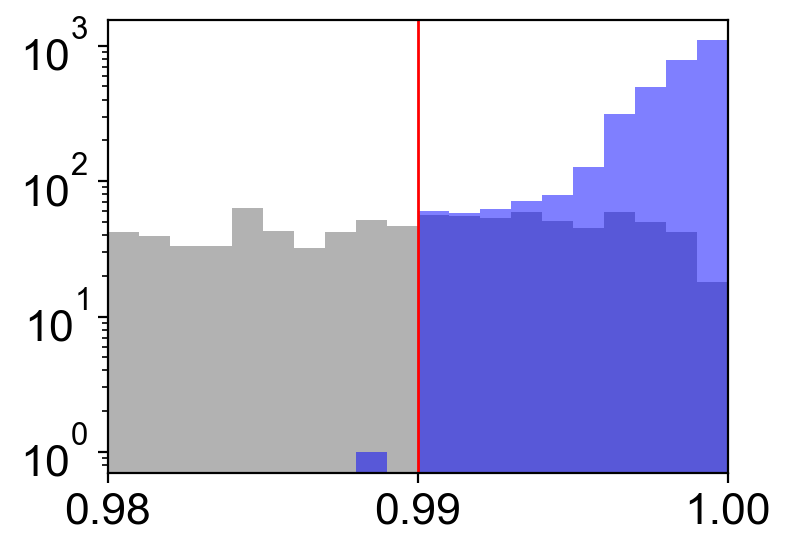

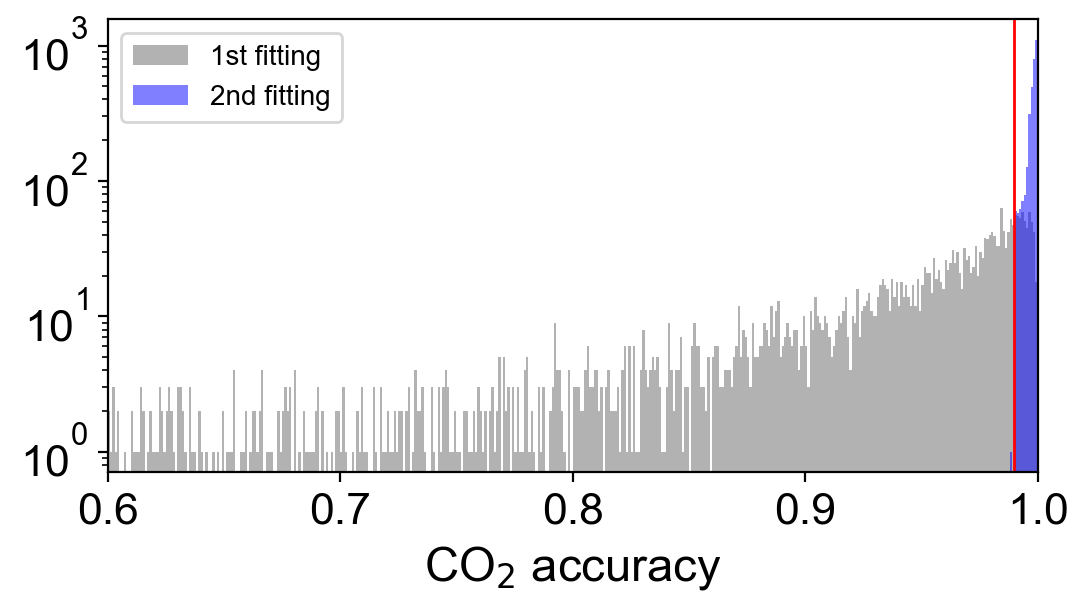

In [10]:
bin_width = 0.001
bins = np.arange(0.2, 1 + bin_width, bin_width)

plt.figure(dpi=200, figsize=(4,3))
plt.hist(-data['Acc_CO2(-R2)'], color='k', alpha=0.3, label='1st fitting', bins=bins)
plt.hist(-data['Acc_CO2(-R2)_2'], color='b', alpha=0.5, label='2nd fitting', bins=bins)
# plt.hist(-data['Error_CO2_con2'], color='b', alpha=0.5, label='3rd fitting', bins=5)
# plt.legend()
plt.axvline(0.99, linewidth=1, c='r')
# plt.xlabel('CO$_2$ accuracy', )
plt.yscale('log')
# plt.ylim([0,10])
plt.xlim([0.98,1])
plt.show()

plt.figure(dpi=200, figsize=(6,3))
plt.hist(-data['Acc_CO2(-R2)'], color='k', alpha=0.3, label='1st fitting', bins=bins)
plt.hist(-data['Acc_CO2(-R2)_2'], color='b', alpha=0.5, label='2nd fitting', bins=bins)
# plt.hist(-data['Error_CO2_con2'], color='b', alpha=0.5, label='3rd fitting', bins=5)
plt.legend()
plt.axvline(0.99, linewidth=1, c='r')
plt.xlabel('CO$_2$ accuracy', )
plt.yscale('log')
# plt.ylim([0,10])
plt.xlim([0.6,1])
plt.show()

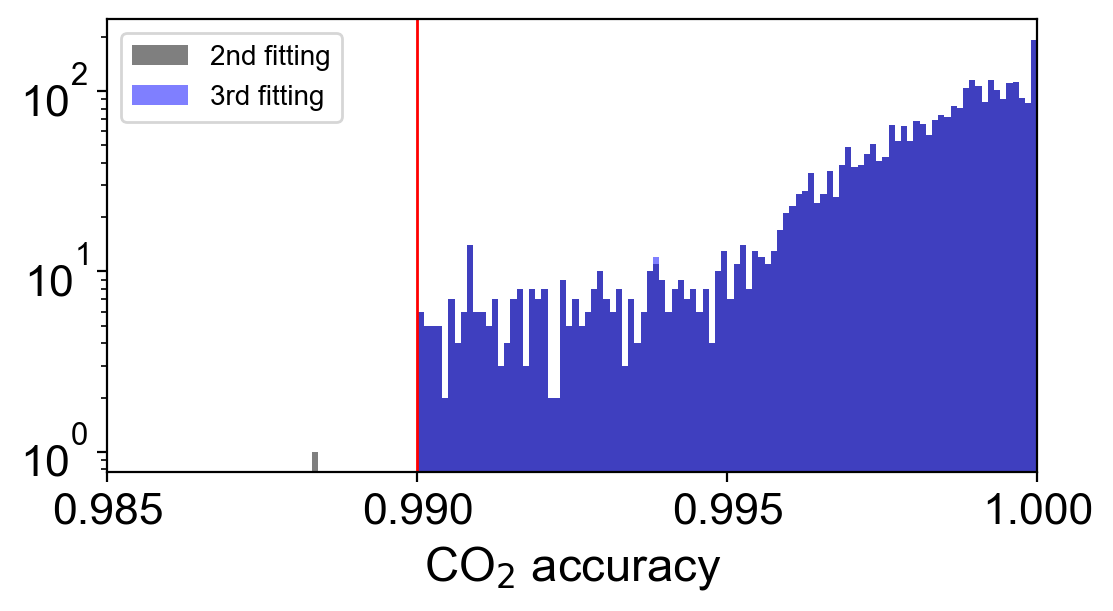

In [11]:
bin_width = 0.0001
bins = np.arange(0.985, 1 + bin_width, bin_width)

plt.figure(dpi=200, figsize=(6,3))
plt.hist(-data['Acc_CO2(-R2)_2'], color='k', alpha=0.5, label='2nd fitting', bins=bins)
plt.hist(-data['Acc_CO2(-R2)_3'], color='b', alpha=0.5, label='3rd fitting', bins=bins)
plt.legend()
plt.axvline(0.99, linewidth=1, c='r')
plt.xlabel('CO$_2$ accuracy', )
plt.yscale('log')
# plt.ylim([0,10])
plt.xlim([0.985,1])
plt.show()

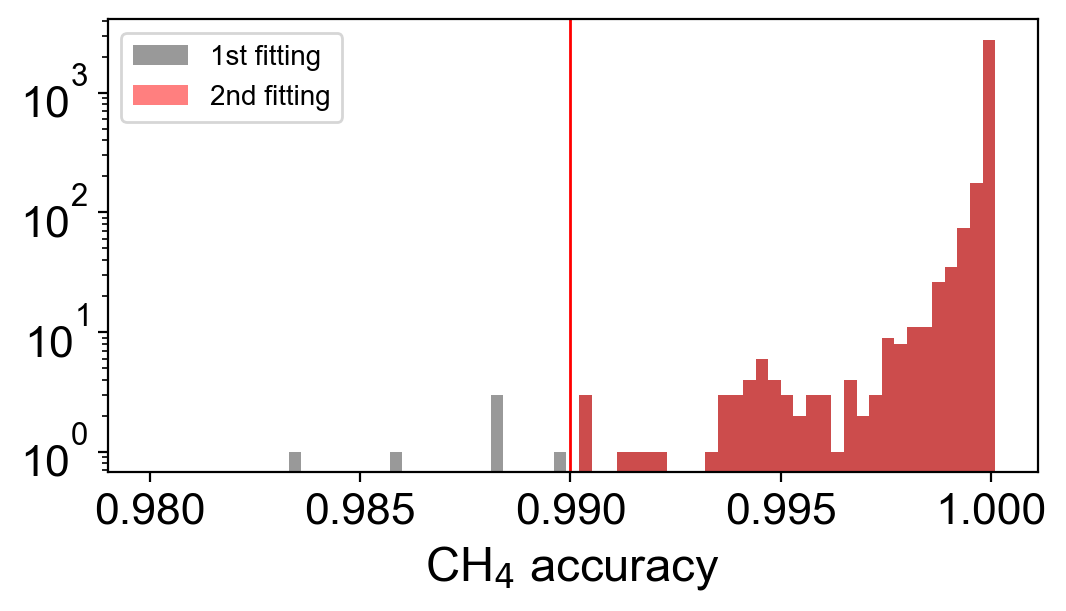

In [12]:
bin_width = 0.0003
bins = np.arange(0.98, 1 + bin_width, bin_width)

plt.figure(dpi=200, figsize=(6,3))
plt.hist(-data['Acc_CH4(-R2)'], color='k', alpha=0.4, label='1st fitting', bins=bins)
plt.hist(-data['Acc_CH4(-R2)_2'], color='r', alpha=0.5, label='2nd fitting', bins=bins)
plt.legend()
plt.axvline(0.99, linewidth=1, c='r')
plt.xlabel('CH$_4$ accuracy', )
plt.yscale('log')
# plt.ylim([2.6e3,3e3])
# plt.xlim([0.985,1])
plt.show()

# Isotherm example

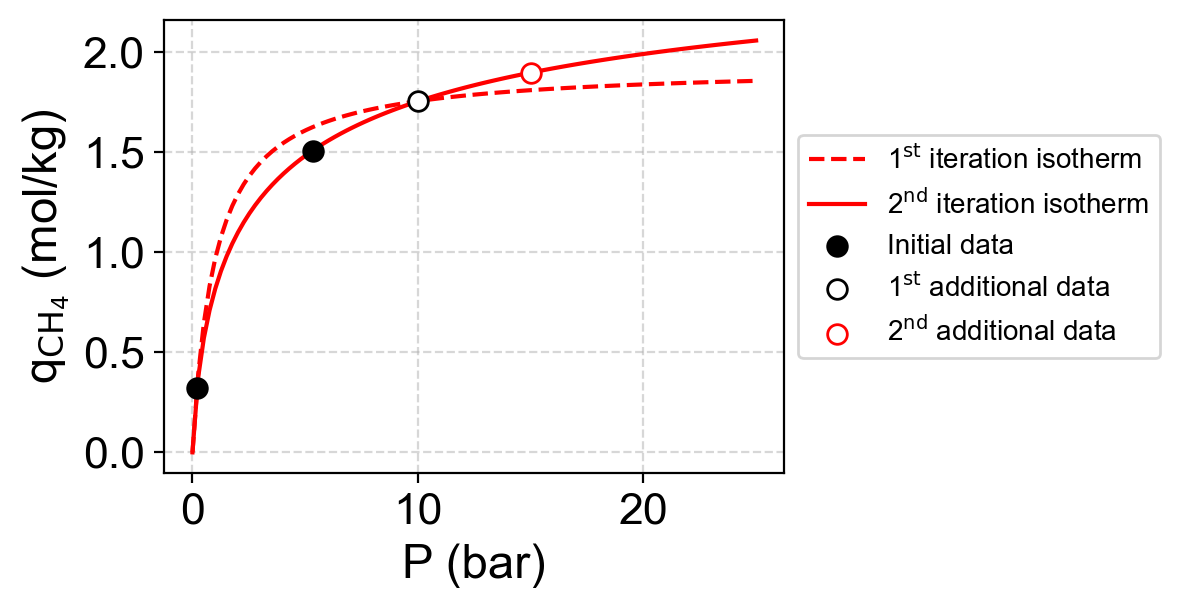

0.99999955


In [13]:
mof_test = data[data['CH4_Isotherm_2']!='NaN']

mof_example = mof_test.iloc[2,:]
iso_1 = MakeIsoFunc(mof_example['CH4_Isotherm_1'], mof_example[['par_1_CH4', 'par_2_CH4']])

P_dom = np.linspace(0,25,100)
q1 = iso_1(P_dom, 0)
tmp1 = (0.2,mof_example['CH4_0.2bar'])
tmp2 = (5.33,mof_example['CH4_5.33bar'])
tmp3 = (mof_example['CH4_3p'],mof_example['CH4_3p_sim'])
sim_list = np.array([tmp1, tmp2, tmp3])

plt.figure(dpi=200, figsize=(4,3))
plt.plot(P_dom, q1, c='r', linestyle='--', label='1$\mathrm{^{st}}$ iteration isotherm')

par = [float(par) for par in mof_example['par_CH4_2'][1:-1].split()] 
iso_2 = MakeIsoFunc(mof_example['CH4_Isotherm_2'], par)
q2 = iso_2(P_dom, 0)
plt.plot(P_dom, q2, c='r', label='2$\mathrm{^{nd}}$ iteration isotherm')

plt.scatter(sim_list[:-1,0], sim_list[:-1,1], c='k', zorder = 4, s=50, label='Initial data')
plt.scatter(sim_list[-1,0], sim_list[-1,1], c='white',edgecolors='k', zorder = 4, s=50, label='1$\mathrm{^{st}}$ additional data')

tmp4 = (mof_example['CH4_4p'],mof_example['CH4_4p_sim'])
sim_list = np.array([tmp1, tmp2, tmp3, tmp4])

plt.scatter(sim_list[-1,0], sim_list[-1,1], c='white', edgecolors='r', zorder = 4, s=50, label='2$\mathrm{^{nd}}$ additional data')

plt.ylabel('q$\mathrm{_{CH_4}}$ (mol/kg)')
plt.xlabel('P (bar)')
plt.grid(alpha=0.5, linestyle = '--')
plt.legend(loc='center left',bbox_to_anchor = (1,0.5))
plt.show()
print('{}'.format(-mof_example['Acc_CH4(-R2)_2']))


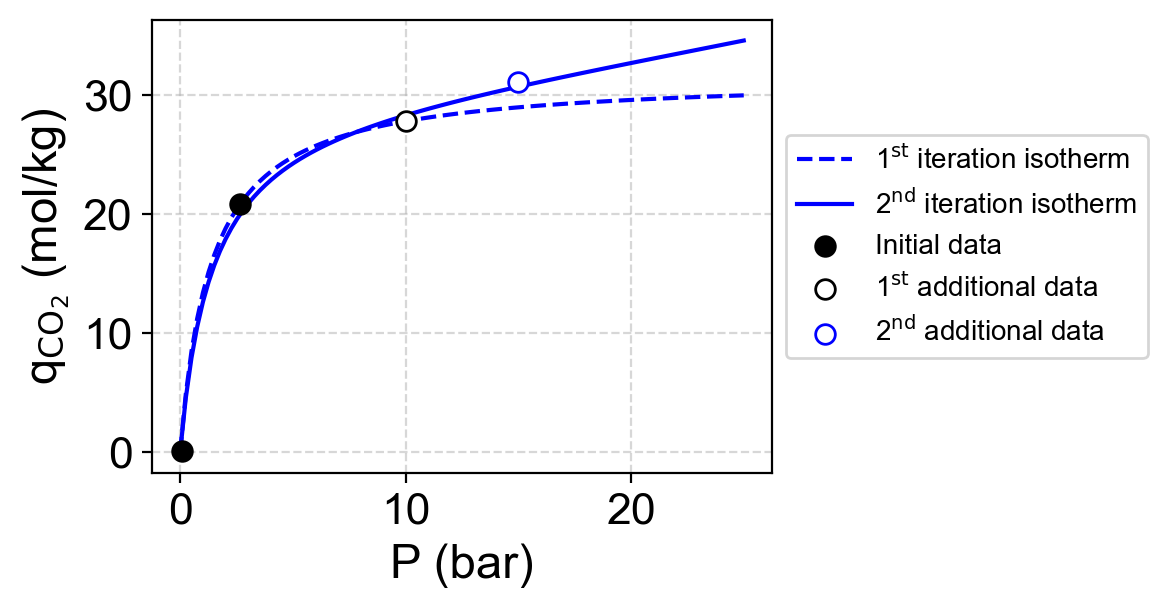

0.991662648


In [14]:
mof_test = data[data['CO2_Isotherm_2']!='NaN']

mof_example = mof_test.iloc[2522,:]
iso_1 = MakeIsoFunc(mof_example['CO2_Isotherm_1'], mof_example[['par_1_CO2', 'par_2_CO2']])

par = [float(par) for par in mof_example['par_CO2_2'][1:-1].split()] 
iso_2 = MakeIsoFunc(mof_example['CO2_Isotherm_2'], par)

P_dom = np.linspace(0,25,100)
q1 = iso_1(P_dom, 0)
tmp1 = (0.1,mof_example['CO2_0.1bar'])
tmp2 = (2.67,mof_example['CO2_2.67bar'])
tmp3 = (mof_example['CO2_3p'],mof_example['CO2_3p_sim'])
sim_list = np.array([tmp1, tmp2, tmp3])

plt.figure(dpi=200, figsize=(4,3))
plt.plot(P_dom, q1, c='b', linestyle='--', label='1$\mathrm{^{st}}$ iteration isotherm')

par = [float(par) for par in mof_example['par_CO2_2'][1:-1].split()] 
iso_2 = MakeIsoFunc(mof_example['CO2_Isotherm_2'], par)
q2 = iso_2(P_dom, 0)
plt.plot(P_dom, q2, c='b', label='2$\mathrm{^{nd}}$ iteration isotherm')

plt.scatter(sim_list[:-1,0], sim_list[:-1,1], c='k', zorder = 4, s=50, label='Initial data')
plt.scatter(sim_list[-1,0], sim_list[-1,1], c='white',edgecolors='k', zorder = 4, s=50, label='1$\mathrm{^{st}}$ additional data')

tmp4 = (mof_example['CO2_4p'],mof_example['CO2_4p_sim'])
sim_list = np.array([tmp1, tmp2, tmp3, tmp4])

plt.scatter(sim_list[-1,0], sim_list[-1,1], c='white', edgecolors='b', zorder = 4, s=50, label='2$\mathrm{^{nd}}$ additional data')

plt.ylabel('q$\mathrm{_{CO_2}}$ (mol/kg)')
plt.xlabel('P (bar)')
plt.grid(alpha=0.5, linestyle = '--')
plt.legend(loc='center left',bbox_to_anchor = (1,0.5))
plt.show()
print('{}'.format(-mof_example['Acc_CO2(-R2)_2']))